In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, losses, optimizers, datasets, Sequential

print('python version:', sys.version.split('\n')[0])
for m in [tf, np, pd, mpl, sns]:
    print(m.__name__, 'version:', m.__version__)

python version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
tensorflow version: 2.3.1
numpy version: 1.18.5
pandas version: 1.1.3
matplotlib version: 3.3.2
seaborn version: 0.11.0


# Download data

In [2]:
dataset_path = keras.utils.get_file('auto-mpg.data', 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data')

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names, 
                          na_values = "?", comment='\t', sep=" ", 
                          skipinitialspace=True)
dataset = raw_dataset.copy()

In [4]:
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


# Preprocessing

In [5]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [6]:
dataset = dataset.dropna() 
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      0
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
origin = dataset.pop('Origin')
dataset['USA'] = (origin == 1)*1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3)*1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

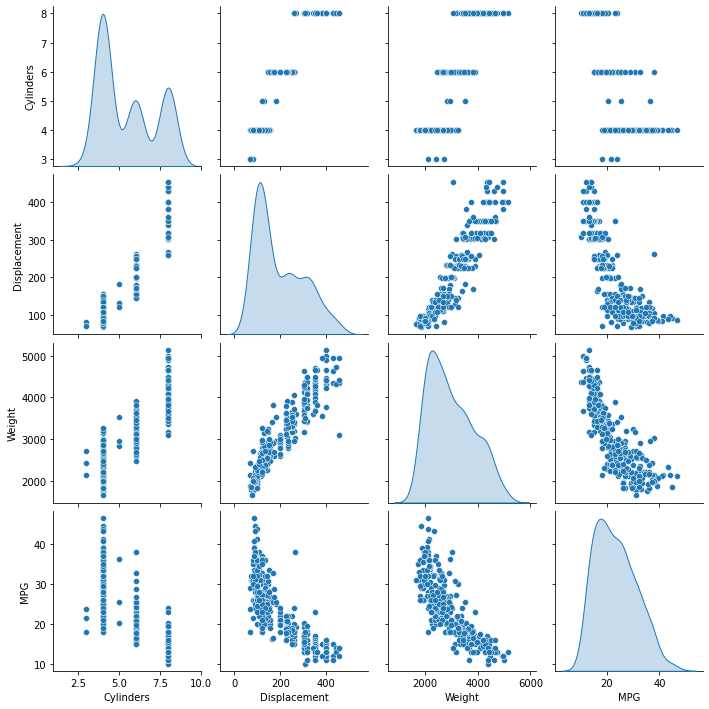

In [9]:
sns.pairplot(train_dataset[["Cylinders", "Displacement", "Weight", "MPG"]], 
diag_kind="kde")
plt.show()

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [12]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
print(normed_train_data.shape,train_labels.shape)
print(normed_test_data.shape, test_labels.shape)

(314, 9) (314,)
(78, 9) (78,)


In [14]:
train_db = tf.data.Dataset.from_tensor_slices((normed_train_data.values, train_labels.values)) 
train_db = train_db.shuffle(100).batch(32)

# Customized network

In [15]:
class Network(keras.Model):
    
    def __init__(self):
        super(Network, self).__init__()
        self.fc1 = layers.Dense(64, activation='relu')
        self.fc2 = layers.Dense(64, activation='relu')
        self.fc3 = layers.Dense(1)
    
    def call(self, inputs, training=None, mask=None):
        x = self.fc1(inputs)
        x = self.fc2(x)
        x = self.fc3(x)
        
        return x

# Train & Test

In [16]:
model = Network()
model.build(input_shape=(None,9)) # None is the amount of batch
optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
model.summary()

Model: "network"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  640       
_________________________________________________________________
dense_1 (Dense)              multiple                  4160      
_________________________________________________________________
dense_2 (Dense)              multiple                  65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [17]:
train_mae_losses = []
test_mae_losses = []
for epoch in range(200):
    for step, (x, y) in enumerate(train_db):
        with tf.GradientTape() as tape:
            out = model(x)
            loss = tf.reduce_mean(losses.MSE(y, out)) # squared
            mae_loss = tf.reduce_mean(losses.MAE(y, out)) # absolute
        
        if step%10 == 0:
            print(epoch, step, float(loss))
            
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    train_mae_losses.append(float(mae_loss))
    out = model(tf.constant(normed_test_data))
    test_mae_losses.append(tf.reduce_mean(losses.MAE(test_labels, out)))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

0 0 623.7542114257812
1 0 620.6843872070312
2 0 519.164306640625
3 0 414.5103454589844
4 0 313.5191650390625
5 0 273.357421875
6 0 187.1887969970703
7 0 143.06884765625
8 0 109.96035766601562
9 0 94.905517578125
10 0 102.09736633300781
11 0 65.14889526367188
12 0 78.34255981445312
13 0 63.01802444458008
14 0 65.08910369873047
15 0 70.26272583007812
16 0 83.11074829101562
17 0 62.59018325805664
18 0 61.89695739746094
19 0 67.75942993164062
20 0 57.85698699951172
21 0 76.44905090332031
22 0 34.63601684570

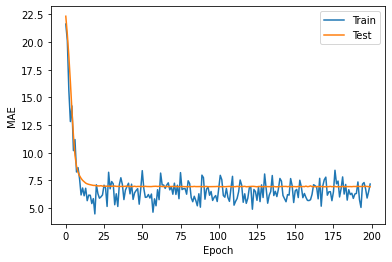

In [18]:
plt.figure()
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.plot(train_mae_losses,  label='Train')

plt.plot(test_mae_losses, label='Test')
plt.legend()
 
# plt.ylim([0,10])
plt.legend()
plt.show() 